In [1]:
import os
import glob
import matplotlib.pyplot as plt
import torch
import imgaug as ia
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import torchvision.models as models
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, dataset, SubsetRandomSampler
from torchvision.datasets import ImageFolder
from PIL import Image
from imgaug import augmenters as iaa
from torchvision.utils import make_grid
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [3]:
zip_name = "/content/drive/MyDrive/Korea it 아카데미/ComputerVision/data/재활용품 vs 새상품.zip"
colab_folder = "/content/drive/MyDrive/Korea it 아카데미/ComputerVision/data/"

In [4]:
# !unzip -q "{zip_name}" -d "{colab_folder}"

In [5]:
data_root = '/content/drive/MyDrive/Korea it 아카데미/ComputerVision/data/5'

In [6]:
def display_images(image_paths, title, max_images = 4) :
    plt.figure(figsize = (12, 3))

    for i, image_path in enumerate(image_paths[: max_images]) :
        img = plt.imread(image_path)

        plt.subplot(1, max_images, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    plt.show()

In [7]:
categories = ['Train General', 'Train Recycle',
              'Val General', 'Val Recycle',
              'Test General', 'Test Recycle']

In [8]:
for category in categories :
    image_paths = glob.glob(f'{data_root}/{category.lower().replace(" ",  "/")}/*')
    print(image_paths)
    display_images(image_paths, category)
    print(f'{category} 총 이미지 수 : {len(image_paths)}')

Output hidden; open in https://colab.research.google.com to view.

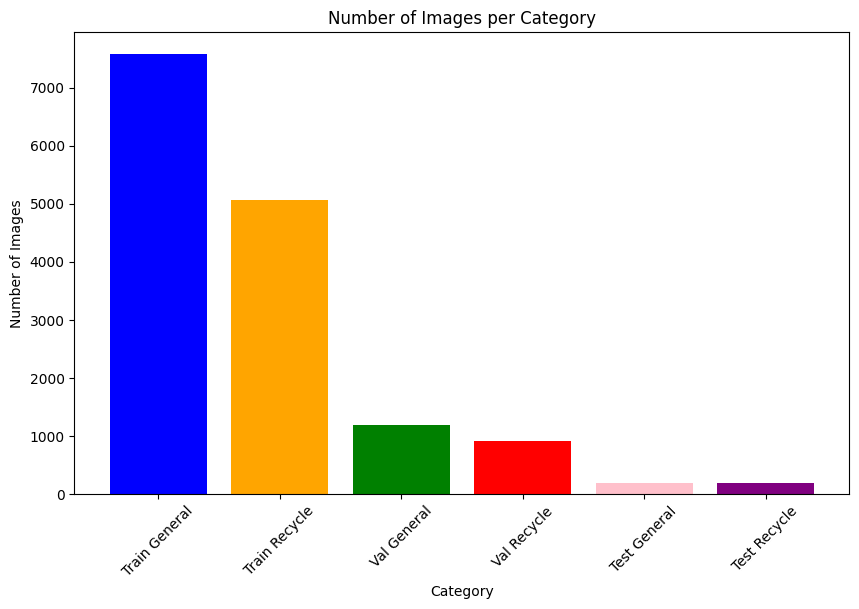

In [9]:
plt.figure(figsize = (10, 6))

plt.bar(categories, [len(glob.glob(f'{data_root}/{category.lower().replace(" ", "/")}/*'))
    for category in categories], color = ['blue', 'orange', 'green', 'red', 'pink', 'purple'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation = 45)

plt.show()

In [10]:
class ImgAugTransform:

    def __init__(self):
        self.aug = iaa.Sequential([
            # 50% 확률로 좌우 반전
            iaa.Fliplr(0.5),

            # 30% 확률로 -20도 ~ 20도 사이로 회전
            # symmetric: 회전 후 이미지를 다시 맞추는 방식(비율)
            iaa.Sometimes(0.3, iaa.Affine(rotate=(-20, 20), mode='symmetric')),

            # 20% 확률로 밝기 변화 적용
            iaa.Sometimes(0.2, iaa.Multiply((0.8, 1.2))),

            # 20% 확률로 CLAHE 적용, 이미지의 대비를 향상
            iaa.Sometimes(0.2, iaa.CLAHE()),

            # 20% 확률로 감마 조정 적용
            iaa.Sometimes(0.2, iaa.GammaContrast())
        ])

    def __call__(self, img):
        img = np.array(img)

        return self.aug.augment_image(img)

In [11]:
class CustomDataset(ImageFolder):

    def __init__(self, root, imgaug=None, transform=None, sample_per_class=None):
        super(CustomDataset, self).__init__(root, transform=transform)
        self.imgaug_transform = imgaug

        if sample_per_class is not None:
            self.samples = self.__reduce_samples(sample_per_class)

    def __reduce_samples(self, sample_per_class):
        class_samples = {}

        for path, target in self.samples:

            if target not in class_samples:
                class_samples[target] = [path]

            else:
                class_samples[target].append(path)

        reduced_samples = []

        for target, paths in class_samples.items():

            if len(paths) > sample_per_class:
                reduced_samples.extend([(path, target) for path in random.sample(paths, sample_per_class)])

            else:
                reduced_samples.extend([(path, target) for path in paths])

        return reduced_samples

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [12]:
pytorch_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [13]:
train_dataset = CustomDataset(f'{data_root}/train', imgaug = ImgAugTransform(), transform = pytorch_transforms, sample_per_class = 128)
val_dataset = CustomDataset(f'{data_root}/val', imgaug = ImgAugTransform(), transform = pytorch_transforms, sample_per_class = 128)

In [14]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)

In [15]:
# DataLoader에서 샘플을 이미지를 load해 show하는 함수
def imshow(img, labels, class_to_idx, size=(20, 20), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):

    # idx_to_class를 생성합니다: 인덱스를 클래스 이름으로 매핑
    idx_to_class = {v : k for k, v in class_to_idx.items()}
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean  # 역정규화
    img = np.clip(img, 0, 1)  # 값이 0과 1 사이에 오도록 클리핑
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')

    # 이미지 위에 레이블 번호와 실제 클래스 이름 출력
    for i, label in enumerate(labels[:8]):  # 첫 8개의 이미지에 대해서만 실행
        class_name = idx_to_class[label.item()]
        x = (i % 4) * (img.shape[1] // 4) + 100  # 텍스트 x 위치
        y = (i // 4) * (img.shape[0] // 2) + 10  # 텍스트 y 위치
        plt.text(x, y, f'{label.item()}, {class_name}', color='black', fontsize=14)

    plt.show()

{'general': 0, 'recycle': 1}


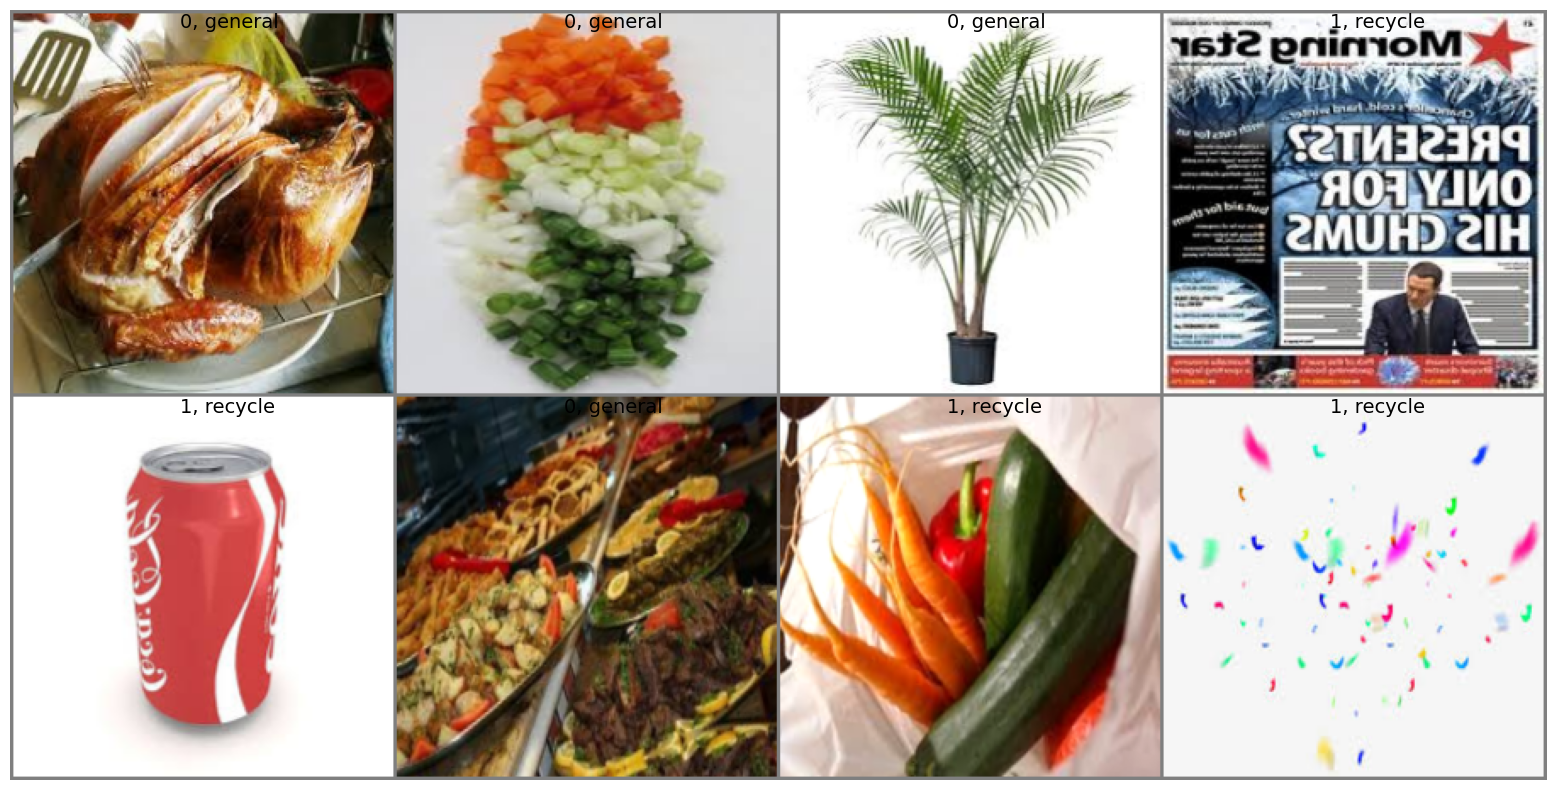

In [16]:
dataiter = iter(train_loader)
images, label = next(dataiter)

class_to_idx = train_loader.dataset.class_to_idx

print(class_to_idx)

imshow(make_grid(images[: 8], nrow = 4), label, class_to_idx, size = (20, 10))

### resnet

* [resnet 논문](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
* 합성곱 신경망(CNN) 아키텍처로 이미지분류, 객체 검출, 이미지 생성 등 다양한 컴퓨터 비전 작업에 사용
* 각 층이 입력을 받아서 그 입력을 변환하여 다음 층으로 전달(입력값을 그대로 다음 층에 전달하는 스킵 연결 또는 숏컷 연결을 추가)
* 기울기 소실 문제 해결, 성능이 매우 깊은 네트워크 임에도 불구하고 매우 좋은 성능, 이미지 분류 작업에서 매우 높은 정확도와 메모리 효율성을 높임

In [17]:
resnet = models.resnet50(pretrained = True)

resnet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
for param in resnet.parameters() :
    param.requires_gard = False

In [19]:
resnet.fc = nn.Linear(2048, 1)

for param in resnet.fc.parameters() :
    param.requires_gard = True

In [20]:
resnet = resnet.to(device)

In [21]:
loss_func = nn.BCEWithLogitsLoss()

In [22]:
def validate_model(model, val_loader, loss_func) :
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad() :

        for inputs, labels in val_loader :
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            outputs = model(inputs)
            val_loss += loss_func(outputs, labels).item()
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total

    return val_loss, val_accuracy

In [23]:
def train_model(optim_name, model, train_loader, val_loader, loss_func, num_epochs = 10) :

    if optim_name == 'SGD' :
        optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

    elif optim_name == 'Adam' :
        optimizer = optim.Adam(model.parameters(), lr = 0.001, betas = (0.9, 0.999))

    elif optim_name == 'RAdam' :
        optimizer = optim.RAdam(model.parameters(), lr = 0.001, betas = (0.9, 0.999))

    else :
        raise ValueError(f'Unsupported optimizer : {optim_name}')

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs) :
        model.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc = f'Epoch {epoch + 1} / {num_epochs}')) :
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss, val_accuracy = validate_model(model, val_loader, loss_func)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'[{optim_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [24]:
train_losses_resnet, val_losses_resnet, val_accuracies_resnet = train_model(
    'RAdam', resnet, train_loader, val_loader, loss_func
)

Epoch 1 / 10: 100%|██████████| 4/4 [02:01<00:00, 30.33s/it]


[RAdam] Epoch 1, Train Loss: 0.685556, Val Loss: 0.708468, Val Accuracy: 47.66%


Epoch 2 / 10: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


[RAdam] Epoch 2, Train Loss: 0.646259, Val Loss: 0.587200, Val Accuracy: 79.30%


Epoch 3 / 10: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


[RAdam] Epoch 3, Train Loss: 0.452886, Val Loss: 0.398368, Val Accuracy: 90.23%


Epoch 4 / 10: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


[RAdam] Epoch 4, Train Loss: 0.276302, Val Loss: 0.253304, Val Accuracy: 93.75%


Epoch 5 / 10: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


[RAdam] Epoch 5, Train Loss: 0.169733, Val Loss: 0.205753, Val Accuracy: 92.58%


Epoch 6 / 10: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


[RAdam] Epoch 6, Train Loss: 0.064911, Val Loss: 0.161659, Val Accuracy: 95.31%


Epoch 7 / 10: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


[RAdam] Epoch 7, Train Loss: 0.029658, Val Loss: 0.136736, Val Accuracy: 94.53%


Epoch 8 / 10: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


[RAdam] Epoch 8, Train Loss: 0.021031, Val Loss: 0.144112, Val Accuracy: 94.92%


Epoch 9 / 10: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


[RAdam] Epoch 9, Train Loss: 0.009387, Val Loss: 0.186641, Val Accuracy: 93.75%


Epoch 10 / 10: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


[RAdam] Epoch 10, Train Loss: 0.006683, Val Loss: 0.221509, Val Accuracy: 94.14%


### DenseNet(Densely Connected Convolutional Networks)
* [논문](https://arxiv.org/abs/1608.06993)
* 일반적인 CNN에서는 레이어들이 순차적으로 연결되어, 이전 레이어의 출력을 다음 레이어의 입력으로 사용 -> densenet은 모든 레이어가 서로 직접 연결되어, 각 레이어가 이전 모든 레이어들의 출력을 입력으로 사용하고, 자신의 출력을 이후 모든 레이어에 전달
* 네트워크 초기 레이어에서 학습한 단순한 특징이 후속 레이어에서 반복적으로 사용될 수 있어 학습이 더욱 효율적
* 모든 레이어가 이전 레이어의 출력에 접근할 수 있기 때문에 역전파 과정에서 기울기가 잘 전달
* 각 레이어가 여러 이전 레이어의 출력을 재사용하기 때문에, 동일한 성능을 유지하면서도 더 적은 매개변수를 사용

In [25]:
model1 = models.densenet169(pretrained = True)

model1










/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [26]:
densenet = models.densenet169(pretrained = True)

for param in densenet.parameters() :
    param.requires_grad = False

densenet.classifier = nn.Linear(1664, 1, bias = True)
densenet.classifier.requires_grad = True
densenet = densenet.to(device)


In [27]:
train_losses_densenet, val_losses_densenet, val_accuracies_densenet = train_model(
    'RAdam', densenet, train_loader, val_loader, loss_func
)

Epoch 1 / 10: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


[RAdam] Epoch 1, Train Loss: 0.686070, Val Loss: 0.734192, Val Accuracy: 44.53%


Epoch 2 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


[RAdam] Epoch 2, Train Loss: 0.680030, Val Loss: 0.724290, Val Accuracy: 47.27%


Epoch 3 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]


[RAdam] Epoch 3, Train Loss: 0.674042, Val Loss: 0.716071, Val Accuracy: 46.88%


Epoch 4 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


[RAdam] Epoch 4, Train Loss: 0.672966, Val Loss: 0.712010, Val Accuracy: 48.83%


Epoch 5 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


[RAdam] Epoch 5, Train Loss: 0.662438, Val Loss: 0.692090, Val Accuracy: 55.47%


Epoch 6 / 10: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


[RAdam] Epoch 6, Train Loss: 0.648220, Val Loss: 0.685533, Val Accuracy: 59.38%


Epoch 7 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


[RAdam] Epoch 7, Train Loss: 0.645952, Val Loss: 0.667511, Val Accuracy: 60.94%


Epoch 8 / 10: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


[RAdam] Epoch 8, Train Loss: 0.637118, Val Loss: 0.658982, Val Accuracy: 65.23%


Epoch 9 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


[RAdam] Epoch 9, Train Loss: 0.624843, Val Loss: 0.646910, Val Accuracy: 68.36%


Epoch 10 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


[RAdam] Epoch 10, Train Loss: 0.613085, Val Loss: 0.633521, Val Accuracy: 69.14%


### EfficientNet
* [논문](https://arxiv.org/abs/1905.11946)
* 모델의 정확성과 효율성 사이의 균형을 잘 맞추는 것으로 알려져 있으며, 특히 대규모 데이터셋에서 뛰어난 성능을 보임
* 기존의 딥러닝 모델을 성능을 높이기 위해 주로 모델의 크기(너비, 깊이)를 늘리거나 입력 미이지의 해상도를 높이는 방식을 사용(계산 비용이 많이 들고 최적의 성능을 내기 어렵다는 문제)
* Compound Scaling: 모델의 깊이, 너비, 해상도를 동시에 조절하는 방법으로, 각 요소를 균형 있게 조정하여 모델 성능을 극대화하는 방식
    * 깊이(Depth): 모델의 레이어 수를 늘려 더 복잡한 패턴을 학습할 수 있게 함
    * 너비(Width): 각 레이어의 채널 수를 늘려서 더 많은 특징을 학습할 수 있게 함
    * 해상도(Image Resolution): 입력 이미지의 크기를 키워서 더 세밀한 정보를 모델이 학습할 수 있게 함

In [28]:
model2 = models.efficientnet_b0(pretrained=True)

model2

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [29]:
efficientnet = models.efficientnet_b0(pretrained=True)

for param in efficientnet.parameters():
    param.requires_grad = False
efficientnet.classifier[1] = nn.Linear(1280, 1)

for param in efficientnet.classifier.parameters():
    param.requires_grad = True
efficientnet = efficientnet.to(device)











In [30]:
train_losses_efficientnet, val_losses_efficientnet, val_accuracies_efficientnet = train_model(
    'RAdam', efficientnet, train_loader, val_loader, loss_func
)

Epoch 1 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


[RAdam] Epoch 1, Train Loss: 0.683351, Val Loss: 0.695823, Val Accuracy: 51.95%


Epoch 2 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


[RAdam] Epoch 2, Train Loss: 0.672824, Val Loss: 0.695742, Val Accuracy: 51.95%


Epoch 3 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


[RAdam] Epoch 3, Train Loss: 0.674364, Val Loss: 0.690484, Val Accuracy: 57.42%


Epoch 4 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


[RAdam] Epoch 4, Train Loss: 0.669979, Val Loss: 0.691697, Val Accuracy: 53.12%


Epoch 5 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


[RAdam] Epoch 5, Train Loss: 0.667458, Val Loss: 0.688052, Val Accuracy: 55.47%


Epoch 6 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


[RAdam] Epoch 6, Train Loss: 0.662620, Val Loss: 0.675934, Val Accuracy: 57.42%


Epoch 7 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


[RAdam] Epoch 7, Train Loss: 0.657840, Val Loss: 0.676057, Val Accuracy: 60.94%


Epoch 8 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


[RAdam] Epoch 8, Train Loss: 0.656969, Val Loss: 0.668115, Val Accuracy: 61.33%


Epoch 9 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


[RAdam] Epoch 9, Train Loss: 0.643041, Val Loss: 0.668092, Val Accuracy: 60.16%


Epoch 10 / 10: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


[RAdam] Epoch 10, Train Loss: 0.644589, Val Loss: 0.665258, Val Accuracy: 62.11%


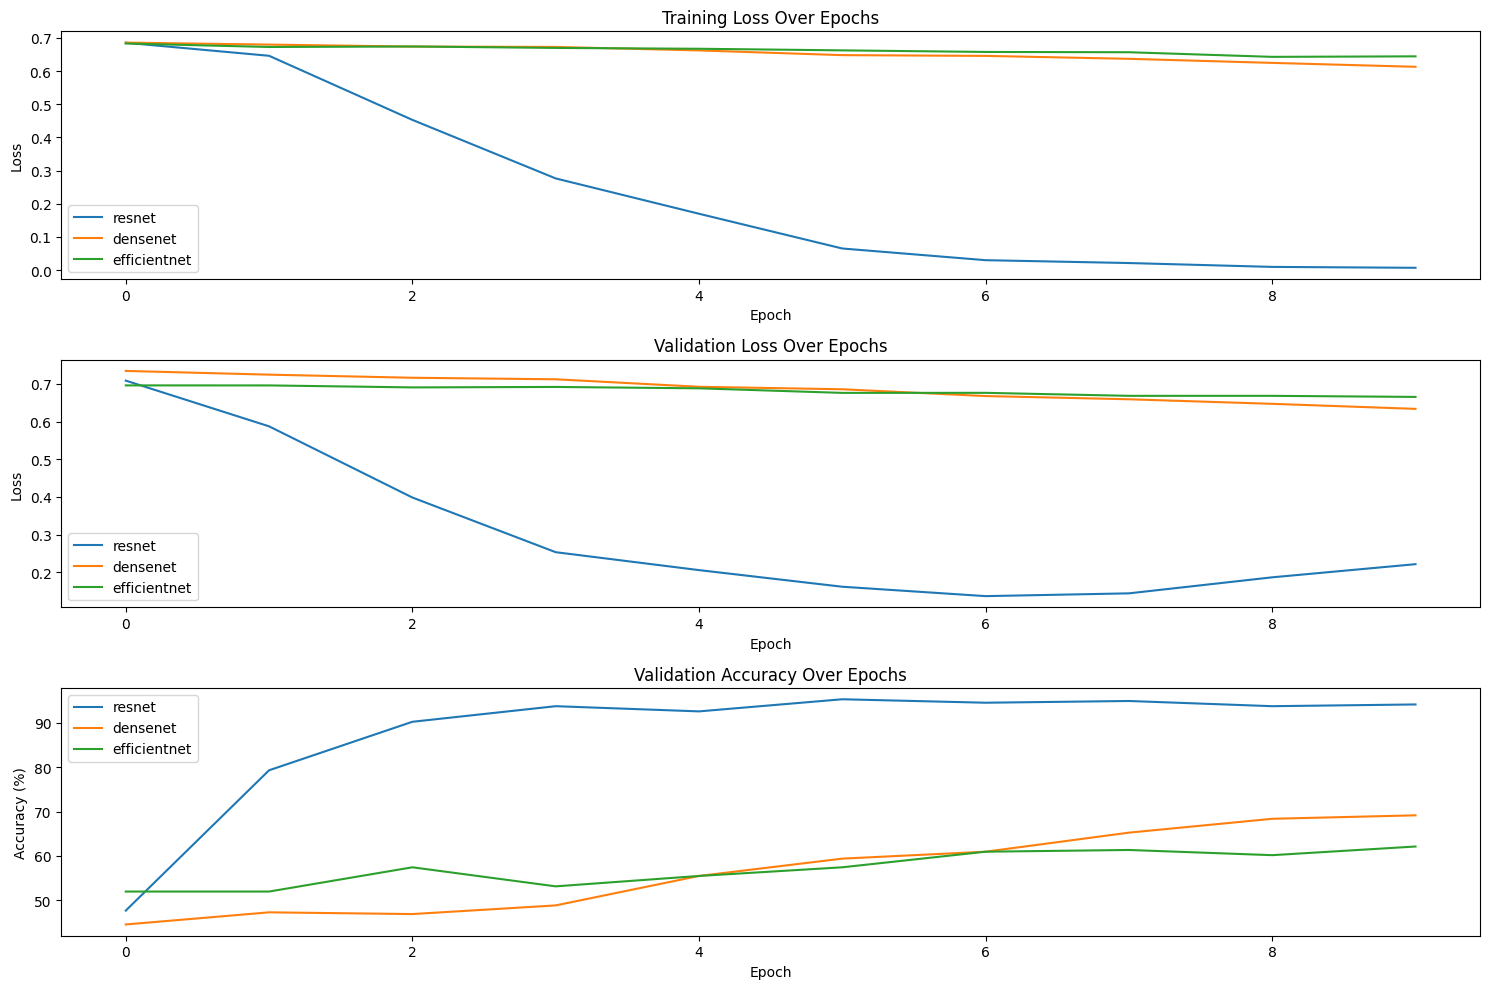

In [31]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))
# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_resnet, label='resnet')
plt.plot(train_losses_densenet, label='densenet')
plt.plot(train_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_resnet, label='resnet')
plt.plot(val_losses_densenet, label='densenet')
plt.plot(val_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_resnet, label='resnet')
plt.plot(val_accuracies_densenet, label='densenet')
plt.plot(val_accuracies_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

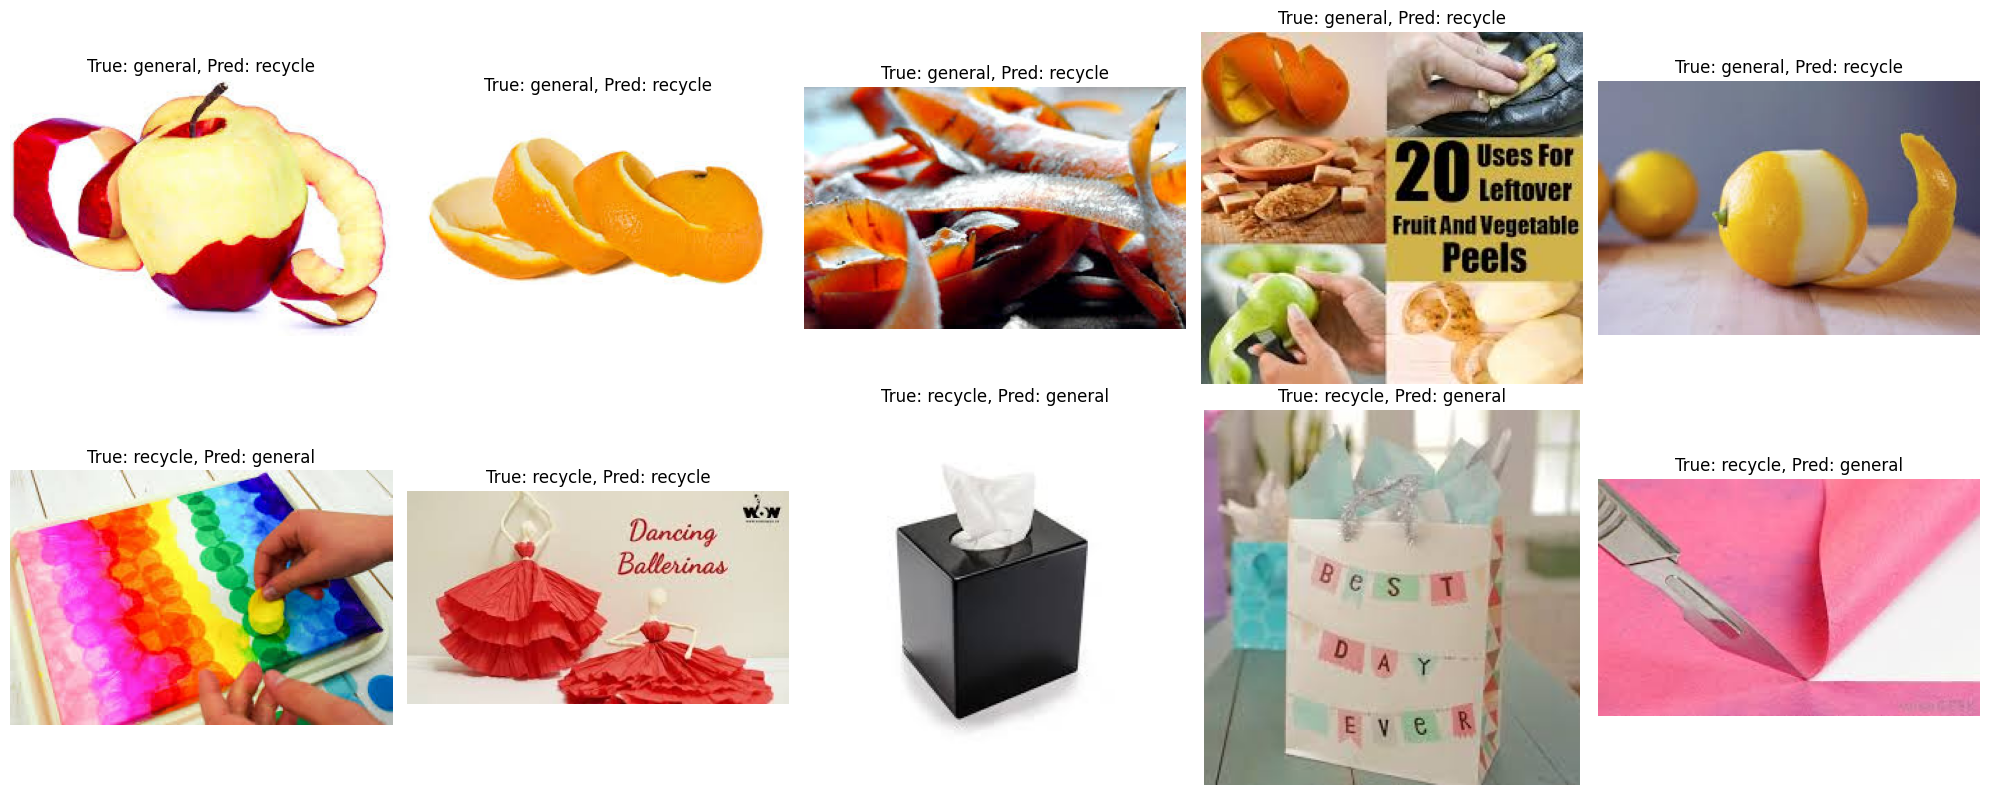

In [32]:
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')

    return transform(image).unsqueeze(0).to(device)

# 클래스별 폴더 경로
class_folders = {
    'general': f'{data_root}/test/general',
    'recycle': f'{data_root}/test/recycle'
}

plt.figure(figsize=(20, 8))
counter = 1

for class_name, folder_path in class_folders.items():
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, pytorch_transforms)
        resnet.eval()

        with torch.no_grad():
            outputs = resnet(image)
            probs = torch.sigmoid(outputs).item()
            prediction = 'general' if probs >= 0.5 else 'recycle'
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')
        counter += 1

plt.tight_layout()
plt.show()

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, class_folders, transform):
    model.eval()
    model.to(device)
    all_preds = []
    all_labels = []

    for class_name, folder_path in class_folders.items():
        image_paths = glob.glob(os.path.join(folder_path, '*'))

        for image_path in image_paths:
            image = load_and_transform_image(image_path, transform)

            with torch.no_grad():
                outputs = model(image)
                probs = torch.sigmoid(outputs).item()
                prediction = 1 if probs >= 0.5 else 0
                all_preds.append(prediction)
                all_labels.append(1 if class_name == 'recycle' else 0)

    # Calculate metrics

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, precision, recall, f1

# Evaluate models

resnet_metrics = evaluate_model(resnet, class_folders, pytorch_transforms)
densenet_metrics = evaluate_model(densenet, class_folders, pytorch_transforms)
efficientnet_metrics = evaluate_model(efficientnet, class_folders, pytorch_transforms)

# Print comparison

print("ResNet50 Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*resnet_metrics))
print("DenseNet169 Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*densenet_metrics))
print("EfficientNetB0 Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(*efficientnet_metrics))


ResNet50 Metrics: Accuracy: 0.9200, Precision: 0.9667, Recall: 0.8700, F1: 0.9158
DenseNet169 Metrics: Accuracy: 0.7850, Precision: 0.8032, Recall: 0.7550, F1: 0.7784
EfficientNetB0 Metrics: Accuracy: 0.6075, Precision: 0.6387, Recall: 0.4950, F1: 0.5577
